<a href="https://colab.research.google.com/github/Taikatou/economy-monte-carlo/blob/main/open_ai_environment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import gym
from gym import spaces
import numpy as np

In [6]:
pip install stable-baselines3[extra]

In [7]:
import gym
from stable_baselines3 import DQN
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO

In [8]:
from enum import IntEnum
class Resource(IntEnum):
    NOTHING = 0
    WOOD = 1
    METAL = 2
    GEM = 3
    DRAGONSCALE = 4

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
FORCE_RANDOM = False
CHOOSE_OPTIMAL = False
config = {  # Configuration 1
    0: {1: 0.3, 2: 0.25, 3: 0.0, 4: 0.0},  # Forest
    1: {1: 0.0, 2: 0.40, 3: 0.1, 4: 0.0},  # Mountain
    2: {1: 0.10, 2: 0.10, 3: 0.20, 4: 0.0},  # Sea
    3: {1: 0.0, 2: 0.10, 3: 0.10, 4: 0.20}  # Volcano
}
for index, value in config.items():
    sum = 1.0
    for key, v in value.items():
        sum -= v
    config[index][0] = sum

In [34]:
class DeepQBanditEnv(gym.Env):
    metadata = {'render.modes': ['console']}

    def __init__(self, arm_probabilities):
        super(DeepQBanditEnv, self).__init__()
        self.arm_probabilities = arm_probabilities
        self.num_arms = len(self.arm_probabilities)
        self.state_size = 4  # Based on context array size
        self.action_space = spaces.Discrete(self.num_arms)
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.state_size,), dtype=np.float32)
        self.reward = 1

    def reset(self):
        # Reset the state of the environment to an initial state
        self.context = np.random.randint(0, 4, size=4)
        self.reward = np.sum(self.context)
        return self.context

    def init(self, new_context):
        self.context = new_context

    def step(self, action):
        reward = self.get_reward(action, self.context)
        info = {}  # Additional information, if any
        self.context = self.new_context
        done = self.context == [0, 0, 0, 0]
        return self.context, reward, done, info

    def render(self, mode='console'):
        if mode == 'console':
            print(f"Current context: {self.context}")

    def get_reward(self, arm, context):
        self.new_context = [x for x in context]
        resource = int(np.random.choice([Resource.NOTHING, Resource.WOOD, Resource.METAL, Resource.GEM, Resource.DRAGONSCALE], p=[self.arm_probabilities[arm][i] for i in range(0, 5)]))
        if resource == 0:
            return -0.05
        if self.new_context[resource - 1] > 0:
            self.new_context[resource - 1] -= 1
        if self.new_context == [0, 0, 0, 0]:
          return 1
        if (np.array(self.new_context) == np.array(context)).all():
          return -0.05
        return 0

env = DeepQBanditEnv(config)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback

In [12]:
class RewardLoggerCallback(BaseCallback):
    def __init__(self, check_freq):
        super(RewardLoggerCallback, self).__init__()
        self.check_freq = check_freq
        self.rewards = []

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            episode_rewards = self.model.ep_info_buffer
            if episode_rewards:
                self.rewards.append(episode_rewards[-1]['r'])
        return True

In [13]:
reward_logger = RewardLoggerCallback(check_freq=1000)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

# Hyperparameters
GAMMA = 0.99
LEARNING_RATE = 0.001
MEMORY_SIZE = 100000
BATCH_SIZE = 64
EPSILON_START = 1.0
EPSILON_END = 0.01
EPSILON_DECAY = 0.995
TARGET_UPDATE = 10

In [35]:
# Q-Network
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = self.fc1(state)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# DQN Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = EPSILON_START

        # Q-Network
        self.q_network = QNetwork(state_size, action_size)
        for param in self.q_network.parameters():
            param.requires_grad = True

        self.target_network = QNetwork(state_size, action_size)
        for param in self.target_network.parameters():
            param.requires_grad = True

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=LEARNING_RATE)

        # Replay memory
        self.memory = deque(maxlen=MEMORY_SIZE)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.random() > self.epsilon:
            state = torch.from_numpy(np.array(state)).float().unsqueeze(0)
            with torch.no_grad():
                action_values = self.q_network(state)
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def replay(self):
        if len(self.memory) < BATCH_SIZE:
            return

        # Sample a batch of experiences
        batch = random.sample(self.memory, BATCH_SIZE)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = torch.from_numpy(np.vstack(states)).float()
        actions = torch.from_numpy(np.vstack(actions)).long()
        rewards = torch.from_numpy(np.vstack(rewards)).float()
        next_states = torch.from_numpy(np.vstack(next_states)).float()
        dones = torch.from_numpy(np.vstack(dones).astype(np.uint8)).float()

        # Compute Q targets for current states
        Q_targets_next = self.target_network(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.q_network(states).gather(1, actions)
        # Compute loss
        loss = nn.MSELoss()(Q_expected, Q_targets)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())


#####################################################################################

import random
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)

total_discounted_rewards = []
# Training loop
num_episodes = 1000  # Adjust this for longer training
for episode in range(num_episodes):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        agent.replay()

    # Reduce epsilon
    if agent.epsilon > EPSILON_END:
        agent.epsilon *= EPSILON_DECAY

    # Update the target network
    if episode % TARGET_UPDATE == 0:
        agent.update_target_network()

    print(f"Episode: {episode}, Total reward: {total_reward}, Epsilon: {agent.epsilon}")
    total_discounted_rewards.append(total_reward)

# Close the environment
env.close()

Episode: 0, Total reward: -0.4500000000000006, Epsilon: 0.995
Episode: 1, Total reward: -0.35000000000000053, Epsilon: 0.990025
Episode: 2, Total reward: -0.5500000000000007, Epsilon: 0.985074875
Episode: 3, Total reward: 0.8, Epsilon: 0.9801495006250001
Episode: 4, Total reward: -0.3000000000000005, Epsilon: 0.9752487531218751
Episode: 5, Total reward: -2.220446049250313e-16, Epsilon: 0.9703725093562657
Episode: 6, Total reward: 0.04999999999999971, Epsilon: 0.9655206468094844
Episode: 7, Total reward: -4.249999999999989, Epsilon: 0.960693043575437
Episode: 8, Total reward: -2.399999999999996, Epsilon: 0.9558895783575597
Episode: 9, Total reward: -1.8499999999999979, Epsilon: 0.9511101304657719
Episode: 10, Total reward: -1.8999999999999977, Epsilon: 0.946354579813443
Episode: 11, Total reward: -2.220446049250313e-16, Epsilon: 0.9416228069143757
Episode: 12, Total reward: -0.5500000000000007, Epsilon: 0.9369146928798039
Episode: 13, Total reward: 0.04999999999999971, Epsilon: 0.932230

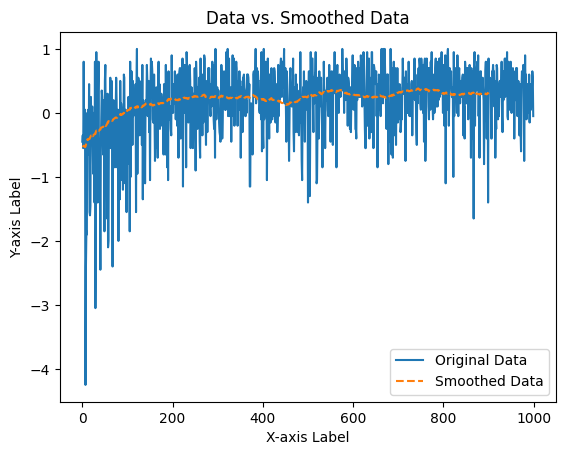

In [36]:
def moving_average(data, window_size):
    """Smooth data by calculating the moving average over a window."""
    if window_size <= 1:
        return data  # No smoothing needed for window size 1 or less

    cumulative_sum = np.cumsum(np.insert(data, 0, 0))
    smoothed_data = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    return smoothed_data

smoothed_data = moving_average(total_discounted_rewards, window_size=100)  # Example window size

# Plotting
plt.plot(total_discounted_rewards, label='Original Data')
plt.plot(smoothed_data, label='Smoothed Data', linestyle='--')
plt.title("Data vs. Smoothed Data")
plt.xlabel("X-axis Label")
plt.ylabel("Y-axis Label")
plt.legend()
plt.show()

In [15]:
import math# Discretize the state space

NUM_BINS = [4, 4, 4, 4]  # Number of bins for discretizing each state dimension


def discretize_state(state, bins):
    discretized = list()
    for i in range(len(state)):
        scaling = (state[i] + abs(bins[i][0])) / (bins[i][1] - bins[i][0])
        new_state = int(round((NUM_BINS[i] - 1) * scaling))
        new_state = min(NUM_BINS[i] - 1, max(0, new_state))
        discretized.append(new_state)
    return tuple(discretized)

# Initialize environment
n_actions = env.action_space.n

# Create bins for discretization
state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
state_bounds[1] = [-0.5, 0.5]  # Limiting range for velocity
state_bounds[3] = [-math.radians(50), math.radians(50)]  # Limiting range for pole angle velocity
bins = [np.linspace(b[0], b[1], NUM_BINS[i] + 1) for i, b in enumerate(state_bounds)]

# Initialize Q-table
q_table = np.zeros(NUM_BINS + [n_actions])

In [17]:
epsilon = EPSILON_START
total_discounted_rewards = []
import random

for episode in range(10000):  # Number of episodes
    discretized_state = discretize_state(env.reset(), bins)
    done = False
    total_discounted_reward = 0
    t = 0  # Time step
    while not done:
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample()  # Explore
        else:
            action = np.argmax(q_table[discretized_state])  # Exploit

        # Take action and observe new state and reward
        next_state, reward, done, _ = env.step(action)
        discretized_next_state = discretize_state(next_state, bins)

        # Update Q-table
        best_next_action = np.argmax(q_table[discretized_next_state])
        td_target = reward + GAMMA * q_table[discretized_next_state][best_next_action]
        q_table[discretized_state + (action,)] += LEARNING_RATE * (td_target - q_table[discretized_state + (action,)])

        discretized_state = discretized_next_state

        total_discounted_reward += (GAMMA ** t) * reward
        t += 1

    total_discounted_rewards.append(total_discounted_reward)

    # Update epsilon
    epsilon = max(EPSILON_END, epsilon * EPSILON_DECAY)

# Close the environment
env.close()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Streaming output truncated to the last 5000 lines.
[0, 3, 0, 0]	[0, 2, 0, 0]
[0, 2, 0, 0]	[0, 2, 0, 0]
[0, 2, 0, 0]	[0, 2, 0, 0]
[0, 2, 0, 0]	[0, 2, 0, 0]
[0, 2, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 1, 0, 0]
[0, 1, 0, 0]	[0, 0, 0, 0]
[0 2 1 0]	[0,

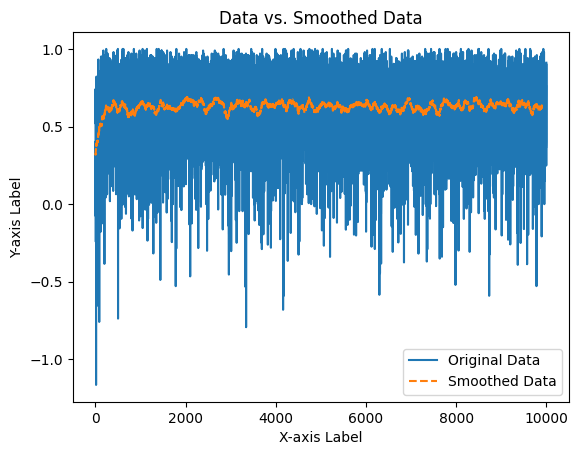

In [18]:
def moving_average(data, window_size):
    """Smooth data by calculating the moving average over a window."""
    if window_size <= 1:
        return data  # No smoothing needed for window size 1 or less

    cumulative_sum = np.cumsum(np.insert(data, 0, 0))
    smoothed_data = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    return smoothed_data

smoothed_data = moving_average(total_discounted_rewards, window_size=100)  # Example window size

# Plotting
plt.plot(total_discounted_rewards, label='Original Data')
plt.plot(smoothed_data, label='Smoothed Data', linestyle='--')
plt.title("Data vs. Smoothed Data")
plt.xlabel("X-axis Label")
plt.ylabel("Y-axis Label")
plt.legend()
plt.show()

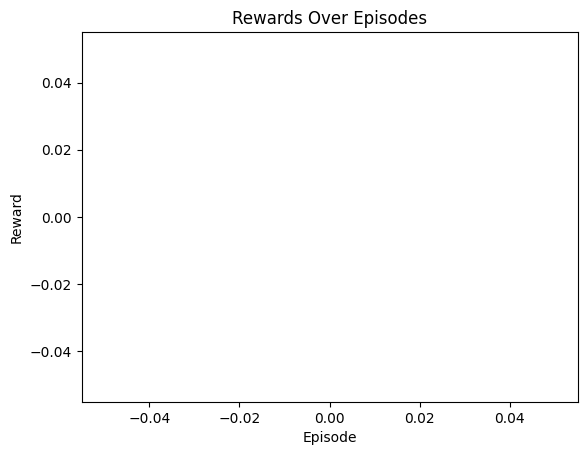

In [ ]:
plt.plot(reward_logger.rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Rewards Over Episodes')
plt.show()

In [20]:
sword_requirements = {
    "Beginner Sword": { Resource.WOOD: 1, Resource.METAL: 1},
    "Intermediate Sword": { Resource.WOOD: 2, Resource.METAL: 2},
    "Advanced Sword": { Resource.WOOD: 2, Resource.METAL: 2, Resource.GEM: 1},
    "Epic Sword": { Resource.WOOD: 2, Resource.METAL: 2, Resource.GEM: 2},
    "Ultimate Sword": { Resource.WOOD: 2, Resource.METAL: 2, Resource.GEM: 2, Resource.DRAGONSCALE: 1}
}

In [21]:
from statistics import mean

In [46]:
random_policy = False
def run_simulation_for_selected_swords(selected_swords, prices, budget, max_iterations=20000, num_runs=3):
    grid_search_results = {}
    for sword, requirements in selected_swords.items():
        avg_steps = []
        for x in range(200):
            # Convert requirements to context format for the bandit
            context = [0, 0, 0, 0]
            for resource, value in requirements.items():
                index = int(resource) - 1
                context[index] = value

            steps = 0
            env.init(context)
            state = env.context
            done = False
            while not done:
                if random_policy:
                    action = env.action_space.sample()
                else:
                    action = agent.act(state)
                next_state, reward, done, _ = env.step(action)
                agent.remember(state, action, reward, next_state, done)
                state = next_state
                steps += 1
            # Record results for this set of requirements
            avg_steps.append(steps)
        grid_search_results[sword] = mean(avg_steps)
    return grid_search_results

FORCE_RANDOM = False
CHOOSE_OPTIMAL = True
adjusted_prices = {"wood": 1, "metal": 2, "gem": 5, "dragonscale": 10}
adjusted_budget = 1000  # Increased budget
max_iterations = 1000
results = run_simulation_for_selected_swords(sword_requirements, adjusted_prices, adjusted_budget, max_iterations)
print(results)
random_policy = True
results = run_simulation_for_selected_swords(sword_requirements, adjusted_prices, adjusted_budget, max_iterations)
print(results)

{'Beginner Sword': 4.88, 'Intermediate Sword': 8.93, 'Advanced Sword': 12.595, 'Epic Sword': 17, 'Ultimate Sword': 20.285}
{'Beginner Sword': 11.74, 'Intermediate Sword': 19.48, 'Advanced Sword': 23.595, 'Epic Sword': 27.69, 'Ultimate Sword': 34.75}


In [43]:
~import random

[3, 1, 0, 1]
[3, 0, 0, 1]
[3, 0, 0, 1]
[3, 0, 0, 1]
[2, 0, 0, 1]
[2, 0, 0, 1]
[2, 0, 0, 1]
[2, 0, 0, 1]
[1, 0, 0, 1]
[1, 0, 0, 1]
[1, 0, 0, 1]
[1, 0, 0, 1]
[1, 0, 0, 1]
[1, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 0]
Episode: 0, Total reward: 1, Epsilon: 0.995
[0, 1, 2, 1]
[0, 1, 2, 1]
[0, 1, 2, 1]
[0, 1, 2, 1]
[0, 1, 2, 1]
[0, 0, 2, 1]
[0, 0, 2, 1]
[0, 0, 2, 1]
[0, 0, 2, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 1, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]
[0, 0, 0, 1]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn